# TODO: Title
**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of the TODO's and/or use more than one cell to complete all the tasks.

In [42]:
# TODO: Install any packages that you might need
import os
import requests
import os
import json
import boto3
import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.pytorch import PyTorchModel
from sagemaker.serializers import IdentitySerializer
from PIL import Image
from IPython.display import Image as ImageDisplay
import io
from tqdm import tqdm

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

from os import listdir
from os.path import isfile, join
from collections import defaultdict
from sagemaker.predictor import Predictor
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics



In [5]:
# TODO: Import any packages that you might need
session = sagemaker.Session()
bucket= session.default_bucket()
print("Bucket Name: {}".format(bucket))
region = session.boto_region_name
print("AWS Region: {}".format(region))
role = sagemaker.get_execution_role()
print("Role Name: {}".format(role))

Bucket Name: sagemaker-us-east-1-277157499543
AWS Region: us-east-1
Role Name: arn:aws:iam::277157499543:role/service-role/AmazonSageMaker-ExecutionRole-20230309T202028


## Data Preparation
**TODO:** Run the cell below to download the data.

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [4]:
train_data =  'train_data'

def download_and_arrange_data(train_data):
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join(train_data, k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

download_and_arrange_data(train_data)

100%|██████████| 1228/1228 [01:59<00:00, 10.25it/s]


100%|██████████| 2299/2299 [03:45<00:00, 10.19it/s]


100%|██████████| 2666/2666 [04:23<00:00, 10.13it/s]


100%|██████████| 2373/2373 [03:50<00:00, 10.32it/s]


100%|██████████| 1875/1875 [02:56<00:00, 10.60it/s]


## Dataset
**TODO:** Explain what dataset you are using for this project. Give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understanding of it. You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

In [6]:
#TODO: Perform any data cleaning or data preprocessing
train_data = "train_data"
main_dirs = os.listdir(train_data)
main_dirs.sort()
num_items = {}
file_lists = {}
for directory in main_dirs:
    file_lists[directory] = [s for s in os.listdir(os.path.join(train_data, directory)) if "jpg" in s]
    file_lists[directory].sort()
    num_items[directory] = len(file_lists[directory])
    print(f'Number of images are {num_items[directory]} images with {directory} items in it.')

Number of images are 1228 images with 1 items in it.
Number of images are 2299 images with 2 items in it.
Number of images are 2666 images with 3 items in it.
Number of images are 2373 images with 4 items in it.
Number of images are 1875 images with 5 items in it.


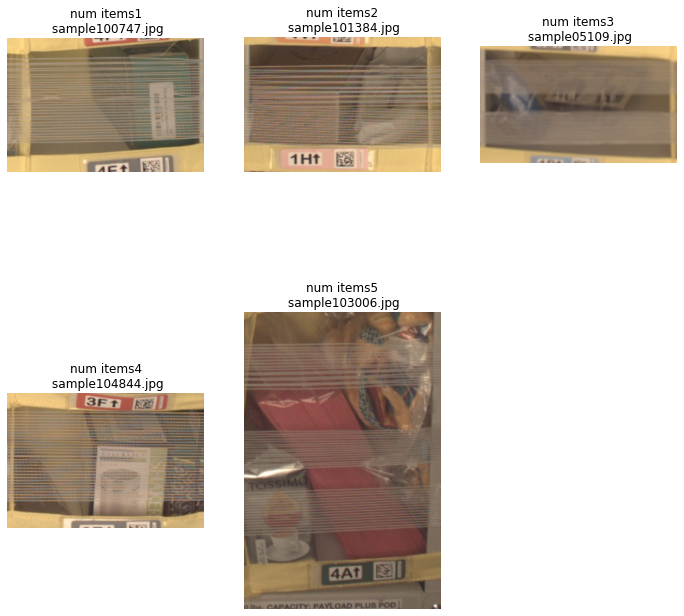

In [7]:
# Plot some of the data
figure = plt.figure(figsize=(12, 12))
cols, rows = 3, 2
for key in num_items.keys():
    sample_idx = random.randint(0, num_items[key]-1)
    img_filename = file_lists[key][sample_idx]
    label = "num items" +key + "\n sample"+ img_filename
    figure.add_subplot(rows, cols, int(key))
    plt.title(label)
    plt.axis("off")
    plt.imshow(mpimg.imread(os.path.join(train_data, key, img_filename)).squeeze(), cmap="gray")
plt.show()


In [8]:
file_list_train = {}
file_list_test = {}
for key in num_items.keys():
    test_no = int(0.2*num_items[key])
    train_no =  int(num_items[key] - test_no)
    file_list_test[key] = []
    file_list_train[key] = []
    for idx, filename in enumerate(file_lists[key]):
        if (idx<(test_no)):
            file_list_test[key].append(filename)
        else:
            file_list_train[key].append(filename)
            
    print(f'num items {key}: Test: {test_no}, Train: {train_no}')

num items 1: Test: 245, Train: 983
num items 2: Test: 459, Train: 1840
num items 3: Test: 533, Train: 2133
num items 4: Test: 474, Train: 1899
num items 5: Test: 375, Train: 1500


In [9]:
new_path =  "new_data"
os.mkdir(new_path)
os.mkdir(os.path.join(new_path, 'test'))
os.mkdir(os.path.join(new_path, 'train'))

In [10]:
for key in num_items.keys():
    os.mkdir(os.path.join(new_path, 'test', key))
    os.mkdir(os.path.join(new_path, 'train', key))

In [11]:
import shutil
for key in num_items.keys():    
    for filename in file_list_test[key]:
        shutil.copy(os.path.join(train_data, key, filename), os.path.join(new_path,'test', key, filename))
    for filename in file_list_train[key]:
        shutil.copy(os.path.join(train_data, key, filename), os.path.join(new_path,'train', key, filename))
        
print("Finished")

Finished


In [ ]:
#TODO: Upload the data to AWS S3

!aws s3 cp new_data s3://sagemaker-us-east-1-277157499543/new_data --recursive


In [13]:
%%capture
!pip install ipywidgets

In [14]:
# Setting seeds to try and ensure we have the same results - this is not guaranteed across PyTorch releases.
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [30]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

## Model Training
**TODO:** This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

<h3>Set up parameters, estimator, and tuner</h3>

In [21]:
from time import gmtime, strftime

In [22]:

tuning_job_name = "imageclassif-job-{}".format(strftime("%d-%H-%M-%S", gmtime()))

In [32]:
#TODO: Declare your model training hyperparameter.
#NOTE: You do not need to do hyperparameter tuning. You can use fixed hyperparameter values
hyperparameters = {
    "batch-size": "512",
    "epochs": 5,
    "lr": "0.01",
}

In [33]:
#TODO: Create your training estimator
estimator = PyTorch(
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    source_dir=".",
    entry_point="train_model.py",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=hyperparameters,
)


In [35]:
train_path = "s3://sagemaker-us-east-1-277157499543/new_data/train" 
test_path = "s3://sagemaker-us-east-1-277157499543/new_data/test"

In [36]:
# TODO: Fit your estimator
estimator.fit({"train": train_path, "test": test_path})


2023-03-17 22:38:37 Starting - Starting the training job...
2023-03-17 22:39:01 Starting - Preparing the instances for trainingProfilerReport-1679092628: InProgress
......
2023-03-17 22:40:01 Downloading - Downloading input data...
2023-03-17 22:40:25 Training - Downloading the training image...
2023-03-17 22:41:02 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-03-17 22:40:51,232 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-03-17 22:40:51,235 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-03-17 22:40:51,244 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-03-17 22:40:51,246 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-03-17 22:41:06,715 sagemaker-training-toolkit INFO     No GPUs 

## Standout Suggestions
You do not need to perform the tasks below to finish your project. However, you can attempt these tasks to turn your project into a more advanced portfolio piece.

### Hyperparameter Tuning
**TODO:** Here you can perform hyperparameter tuning to increase the performance of your model. You are encouraged to 
- tune as many hyperparameters as you can to get the best performance from your model
- explain why you chose to tune those particular hyperparameters and the ranges.


In [37]:

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 256]),
    "epochs": IntegerParameter(3, 9)
}



In [38]:
#TODO: Create your training estimator
objective_metric_name = "average test accuracy"
objective_type = "Maximize"
metric_definitions = [{"Name": "average test accuracy", "Regex": "Testing Loss: ([0-9\\.]+)"}]


In [40]:
# TODO: Fit your estimator
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=6,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [ ]:
# TODO: Find the best hyperparameters
tuner.fit({"train": train_path, "test": test_path})
 # TODO: Remember to include your data channels


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [43]:
exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name='pytorch-training-230317-2322')

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

,batch-size,epochs,lr,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,"""32""",5.0,0.100000,pytorch-training-230317-2322-006-2a1d2546,Completed,13.260614,2023-03-18 01:19:19+00:00,2023-03-18 01:51:44+00:00,1945.0
1,"""32""",6.0,0.020098,pytorch-training-230317-2322-005-b2e5b688,Completed,3.464577,2023-03-18 01:01:55+00:00,2023-03-18 01:41:27+00:00,2372.0
3,"""64""",8.0,0.002921,pytorch-training-230317-2322-003-ba4f5010,Completed,1.533824,2023-03-17 23:58:20+00:00,2023-03-18 00:54:41+00:00,3381.0
5,"""32""",5.0,0.001889,pytorch-training-230317-2322-001-c800af0b,Completed,1.533089,2023-03-17 23:24:03+00:00,2023-03-17 23:58:03+00:00,2040.0
2,"""256""",9.0,0.002187,pytorch-training-230317-2322-004-f9898712,Completed,1.503722,2023-03-18 00:10:37+00:00,2023-03-18 01:18:20+00:00,4063.0
4,"""32""",7.0,0.001915,pytorch-training-230317-2322-002-39c52b8b,Completed,1.499674,2023-03-17 23:24:03+00:00,2023-03-18 00:09:16+00:00,2713.0


In [46]:
tuner_metrics = sagemaker.HyperparameterTuningJobAnalytics(hyperparameter_tuning_job_name='pytorch-training-230317-2322')

In [47]:
df = tuner_metrics.dataframe()
total_time = df["TrainingElapsedTimeSeconds"].sum() / 3600
print("The total training time is {:.2f} hours".format(total_time))
df["TrainingJobStatus"].value_counts()

The total training time is 4.59 hours


Completed    6
Name: TrainingJobStatus, dtype: int64

In [48]:
df[df.TrainingJobStatus == "Completed"]

,batch-size,epochs,lr,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,"""32""",5.0,0.100000,pytorch-training-230317-2322-006-2a1d2546,Completed,13.260614,2023-03-18 01:19:19+00:00,2023-03-18 01:51:44+00:00,1945.0
1,"""32""",6.0,0.020098,pytorch-training-230317-2322-005-b2e5b688,Completed,3.464577,2023-03-18 01:01:55+00:00,2023-03-18 01:41:27+00:00,2372.0
2,"""256""",9.0,0.002187,pytorch-training-230317-2322-004-f9898712,Completed,1.503722,2023-03-18 00:10:37+00:00,2023-03-18 01:18:20+00:00,4063.0
3,"""64""",8.0,0.002921,pytorch-training-230317-2322-003-ba4f5010,Completed,1.533824,2023-03-17 23:58:20+00:00,2023-03-18 00:54:41+00:00,3381.0
4,"""32""",7.0,0.001915,pytorch-training-230317-2322-002-39c52b8b,Completed,1.499674,2023-03-17 23:24:03+00:00,2023-03-18 00:09:16+00:00,2713.0
5,"""32""",5.0,0.001889,pytorch-training-230317-2322-001-c800af0b,Completed,1.533089,2023-03-17 23:24:03+00:00,2023-03-17 23:58:03+00:00,2040.0


In [50]:
import bokeh
import bokeh.io

bokeh.io.output_notebook()
from bokeh.plotting import figure, show
from bokeh.models import HoverTool

import pandas as pd

df_parent_objective_value = df[df["FinalObjectiveValue"] > -float("inf")]

p = figure(
    plot_width=900,
    plot_height=400,
    x_axis_type="datetime",
    x_axis_label="datetime",
    y_axis_label=objective_metric_name,
)
p.circle(
    source=df_parent_objective_value, x="TrainingStartTime", y="FinalObjectiveValue", color="black"
)

show(p)

Loading BokehJS ...

In [51]:
best_estimator=tuner.best_estimator()


2023-03-18 01:51:46 Starting - Found matching resource for reuse
2023-03-18 01:51:46 Downloading - Downloading input data
2023-03-18 01:51:46 Training - Training image download completed. Training in progress.
2023-03-18 01:51:46 Uploading - Uploading generated training model
2023-03-18 01:51:46 Completed - Resource retained for reuse


In [52]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"average test accuracy"',
 'batch-size': '"32"',
 'epochs': '5',
 'lr': '0.1',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-03-17-23-21-30-661"',
 'sagemaker_program': '"train_model.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-277157499543/pytorch-training-2023-03-17-23-21-30-661/source/sourcedir.tar.gz"'}

In [54]:
hyperparameters = {"batch-size": int(best_estimator.hyperparameters()['batch-size'].replace('"', '')), \
                   "lr": best_estimator.hyperparameters()['lr'],
                  'epochs':  best_estimator.hyperparameters()['epochs']}
hyperparameters

{'batch-size': 32, 'lr': '0.1', 'epochs': '5'}

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [55]:
# TODO: Deploy your model to an endpoint
modellocation=estimator.model_data

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


In [56]:
# TODO: Run an prediction on the endpoint
class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )


In [57]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
pytorch_model = PyTorchModel(model_data=modellocation, role=role, entry_point='inference.py',py_version='py36',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor) 

predictor=pytorch_model.deploy(initial_instance_count=1, instance_type="ml.m5.large") 

-----!

In [58]:
predictor.serializer = IdentitySerializer("image/jpeg")

def identify_num_objects(image_path):    
    buf = io.BytesIO()
    Image.open(image_path).save(buf, format="JPEG")
    response = predictor.predict(buf.getvalue())

    return list(response[0]).index(max(response[0]))




In [72]:
# TODO: Cost Analysis
model_responses = defaultdict(lambda: list())

for i in range(2, 6):
    path =  f"new_data/test/{i}/"
    for f in listdir(path):
        file_path = f"{path}{f}"
        model_responses[i].append(identify_num_objects(file_path))

### Accuracy

In [73]:
correct = 0

for i in range(1, 6):
    partial = len(list(filter(lambda x: x == i, model_responses[i])))
    correct += partial
    print(f"Accuracy for {i} objects: {partial/200}")

print(f"Mean Accuracy: {correct/1000}")

Accuracy for 1 objects: 0.0
Accuracy for 2 objects: 0.7
Accuracy for 3 objects: 0.32
Accuracy for 4 objects: 0.59
Accuracy for 5 objects: 0.0
Mean Accuracy: 0.322


### Rmse


In [75]:
import math
rsme = {}

for i in range(1, 6):
    rsme[i] = sum(list(map(lambda x: (x - i) ** 2, model_responses[i])))
    print(f"RSME for {i} objects: {math.sqrt(rsme[i]/200)}")

print(f"Total RSME: {math.sqrt(sum(rsme.values())/1000)}")

RSME for 1 objects: 0.0
RSME for 2 objects: 1.5362291495737217
RSME for 3 objects: 2.2494443758403984
RSME for 4 objects: 3.0298514815086235
RSME for 5 objects: 3.5735136770411273
Total RSME: 2.4236336356801123


In [ ]:
# delet end point
predictor.delete_endpoint()
